# **Experiment Notebook**



In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<hr>

## A. Project


In [2]:
Type = 'Anomaly Detection'

In [3]:
group_id = '34'

In [4]:
student_name = 'Niketh Damodaran'

In [5]:
student_id = '25159512'

<hr>

## B. Business Understanding


In [6]:
business_use_case = 'Helping the Fraud Monitoring Team to identify transactions that deviate significantly from a customer\'s historic spending patterns which may indicate fraudulent transaction or a transaction that requires special attention.'

In [7]:
business_expectations = 'To help filter out anomalous transactions from normal transactions that will help narrrow down the identification of true fraudulent transactions'

<hr>

## C. Data Understanding


### C.0 Import Packages

In [8]:
# Pandas for data handling
import pandas as pd

# Scikit Learn for ML training
import sklearn

# Altair for plotting
import altair as alt

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

<hr>

### C.1   Load Datasets

In [9]:
df = pd.read_csv('df_50up.csv') #combined dataset that is saved in EDA notebook.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260740 entries, 0 to 260739
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   cc_num       260740 non-null  int64  
 1   acct_num     260740 non-null  int64  
 2   trans_num    260740 non-null  object 
 3   unix_time    260740 non-null  int64  
 4   category     260740 non-null  object 
 5   amt          260740 non-null  float64
 6   is_fraud     260740 non-null  int64  
 7   merchant     260740 non-null  object 
 8   merch_lat    260740 non-null  float64
 9   merch_long   260740 non-null  float64
 10  area         260740 non-null  object 
 11  gender       260740 non-null  object 
 12  hour         260740 non-null  int64  
 13  amnt_log     260740 non-null  float64
 14  day_of_week  260740 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 29.8+ MB


### C.2 Define Target variable

In [11]:
target_definition_executive_summary = 'As it\'s a semi supervised learning approach, we will use is_fraud as the target feature for evaluating the performance of the model.'

> Rationale: All the anomalous transactions flagged by our model will need to checked if its really fraudulent or not. Because of which, is_fraud feature is used here as the target variable.

<hr>

### C.3 Explore Target variable

In [12]:



target_name = 'is_fraud'

In [13]:
# <fill_this>
df[target_name].value_counts()

is_fraud
0    259564
1      1176
Name: count, dtype: int64

> Insights: In this dataset 1176 transactions are labelled as fraud

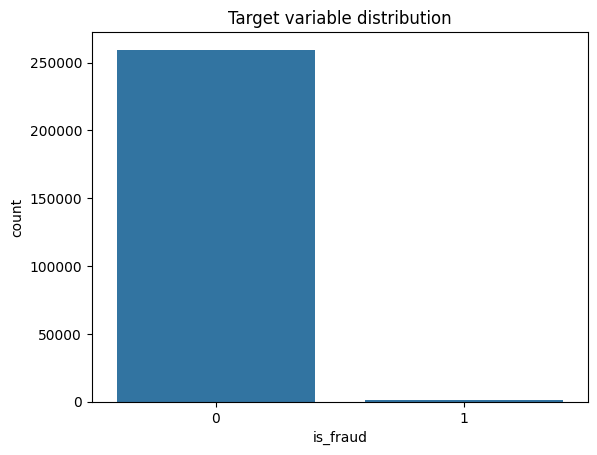

In [14]:
sns.countplot(x = target_name, data = df)

plt.title('Target variable distribution')

plt.show()


> Insights:  As can been in the plot, it is highly imbalanced.

> Considerations: We will have to focus on recall score of the model to evaluate the performance 

> Issues found: only few samples for known fraud transactions.

<hr>

### C.4 Explore Variables of Interest


#### C.4.a Feature "area"

In [15]:
df['area'].value_counts()

area
urban    249601
rural     11139
Name: count, dtype: int64

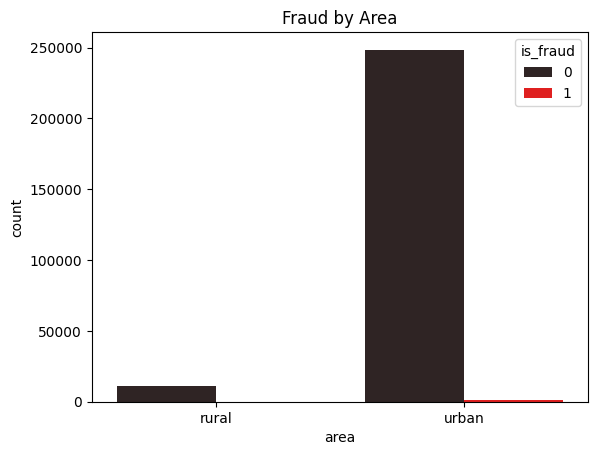

In [16]:
sns.countplot(x = 'area', data = df, color = 'red', hue = 'is_fraud')
plt.title('Fraud by Area')
plt.show()

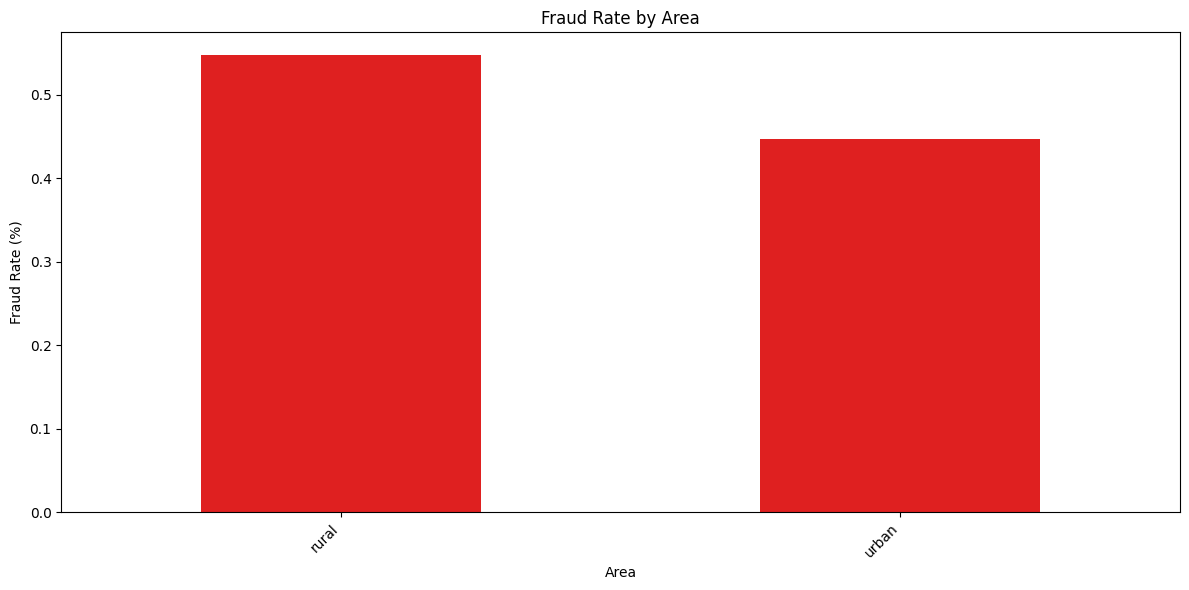

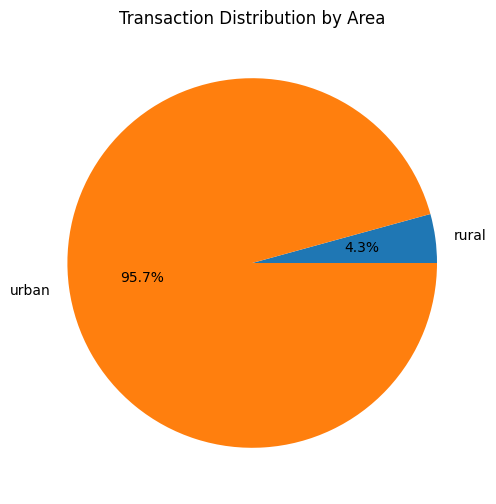


Fraud Analysis Summary by Area:
Highest Risk Area: rural (0.55%)
Lowest Risk Area: urban (0.45%)
Average Fraud Rate: 0.50%

Detailed Area Statistics:
 area  total_transactions  fraud_transactions  fraud_rate  pct_of_total_transactions
rural               11139                  61        0.55                       4.27
urban              249601                1115        0.45                      95.73


In [17]:
def analyze_fraud_by_area(df):

    area_stats = df.groupby('area').agg(
        total_transactions=('is_fraud', 'count'),
        fraud_transactions=('is_fraud', 'sum'),
        fraud_rate=('is_fraud', lambda x: (x.sum() / len(x)) * 100)
    ).reset_index()

    area_stats_sorted = area_stats.sort_values('fraud_rate', ascending=False)

    area_stats['pct_of_total_transactions'] = (
        area_stats['total_transactions'] / area_stats['total_transactions'].sum() * 100
    ) 



    plt.figure(figsize=(12, 6))
    sns.barplot(x='area', y='fraud_rate', color='red', width=0.5, data=area_stats_sorted)
    plt.title('Fraud Rate by Area')
    plt.xlabel('Area')
    plt.ylabel('Fraud Rate (%)')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()  
    plt.show()


    plt.figure(figsize=(10, 6))
    plt.pie(area_stats['pct_of_total_transactions'], labels=area_stats['area'], autopct='%1.1f%%')
    plt.title('Transaction Distribution by Area')
    plt.show()

    summary_stats = {
        'highest_risk_area': area_stats_sorted.iloc[0]['area'],
        'max_fraud_rate': area_stats_sorted.iloc[0]['fraud_rate'],
        'lowest_risk_area': area_stats_sorted.iloc[-1]['area'],
        'min_fraud_rate': area_stats_sorted.iloc[-1]['fraud_rate'],
        'avg_fraud_rate': area_stats['fraud_rate'].mean()
    }

    return area_stats, summary_stats

area_stats, summary = analyze_fraud_by_area(df)

print("\nFraud Analysis Summary by Area:")
print(f"Highest Risk Area: {summary['highest_risk_area']} ({summary['max_fraud_rate']:.2f}%)")
print(f"Lowest Risk Area: {summary['lowest_risk_area']} ({summary['min_fraud_rate']:.2f}%)")
print(f"Average Fraud Rate: {summary['avg_fraud_rate']:.2f}%")

print("\nDetailed Area Statistics:")
print(area_stats.round(2).to_string(index=False))

> Insights: Urban areas have larger volume of transactions as well as slightly decreased fraud rate.

> Considerations: None

> Issues found: None.

#### C.4.b Feature "Gender"

In [18]:
df['gender'].value_counts()

gender
F    145101
M    115639
Name: count, dtype: int64

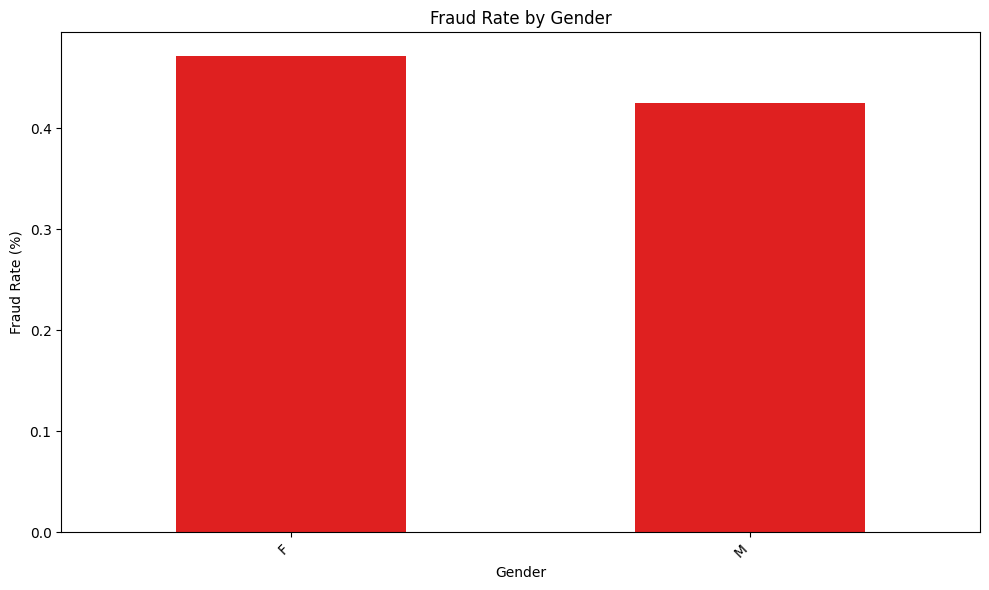

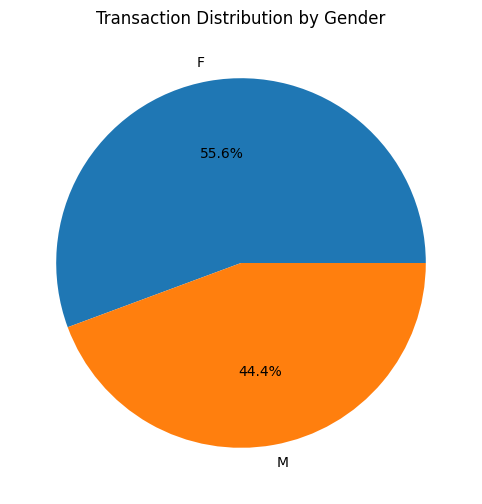


Fraud Analysis Summary by Gender:
Highest Risk Gender: F (0.47%)
Lowest Risk Gender: M (0.43%)
Average Fraud Rate: 0.45%

Detailed Gender Statistics:
gender  total_transactions  fraud_transactions  fraud_rate  pct_of_total_transactions
     F              145101                 684        0.47                      55.65
     M              115639                 492        0.43                      44.35


In [19]:
def analyze_fraud_by_gender(df):
    gender_stats = df.groupby('gender').agg(
        total_transactions=('is_fraud', 'count'),
        fraud_transactions=('is_fraud', 'sum'),
        fraud_rate=('is_fraud', lambda x: (x.sum() / len(x)) * 100)
    ).reset_index()

    gender_stats_sorted = gender_stats.sort_values('fraud_rate', ascending=False)

    gender_stats['pct_of_total_transactions'] = (
        gender_stats['total_transactions'] / gender_stats['total_transactions'].sum() * 100
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(x='gender', y='fraud_rate', color='red', width=0.5, data=gender_stats_sorted)
    plt.title('Fraud Rate by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Fraud Rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.pie(gender_stats['pct_of_total_transactions'], 
            labels=gender_stats['gender'], 
            autopct='%1.1f%%')
    plt.title('Transaction Distribution by Gender')
    plt.show()

    summary_stats = {
        'highest_risk_gender': gender_stats_sorted.iloc[0]['gender'],
        'max_fraud_rate': gender_stats_sorted.iloc[0]['fraud_rate'],
        'lowest_risk_gender': gender_stats_sorted.iloc[-1]['gender'],
        'min_fraud_rate': gender_stats_sorted.iloc[-1]['fraud_rate'],
        'avg_fraud_rate': gender_stats['fraud_rate'].mean()
    }

    return gender_stats, summary_stats

gender_stats, summary = analyze_fraud_by_gender(df)

print("\nFraud Analysis Summary by Gender:")
print(f"Highest Risk Gender: {summary['highest_risk_gender']} ({summary['max_fraud_rate']:.2f}%)")
print(f"Lowest Risk Gender: {summary['lowest_risk_gender']} ({summary['min_fraud_rate']:.2f}%)")
print(f"Average Fraud Rate: {summary['avg_fraud_rate']:.2f}%")

print("\nDetailed Gender Statistics:")
print(gender_stats.round(2).to_string(index=False))

> Insights: F have more transactions recorded compared to M . Both have similar fraud rate

> Considerations: None

> Issues found: none.

## D. Feature Selection


In [20]:
feature_selection_executive_summary = 'The features are selected based on their variance with respect to the fraud status of a transaction.'

> Rationale: We are selecting features initially that showed variance with the is_fraud feature.  cc_num and acct_num are used to track the customer details

In [21]:


features_list = ['cc_num','acct_num','category', 'amount', 'hour','unix_time','day_of_week']

> Results:  Initial features are selected 

<hr>

## E. Data Preparation

In [22]:
data_preparation_executive_summary = 'Data Preparation is done in the EDA itself, so further cleaning is required at the moment.'

## F. Feature Engineering

In [23]:
feature_engineering_executive_summary = 'We will create features that are specific to a customer by using cc_num to understand customer\'s historic transaction patterns,.'

### F3. New Feature "amnt_dev_log"

> Rationale: This is to compute how much the transaction amount is deviating from the usual average spending habit of a customer.

In [24]:
df['avg_log_amt'] = df.groupby('cc_num')['amnt_log'].transform('mean')

df['amnt_dev_log'] = np.abs(df['amnt_log'] - df['avg_log_amt'])/np.std(df['amnt_log'])

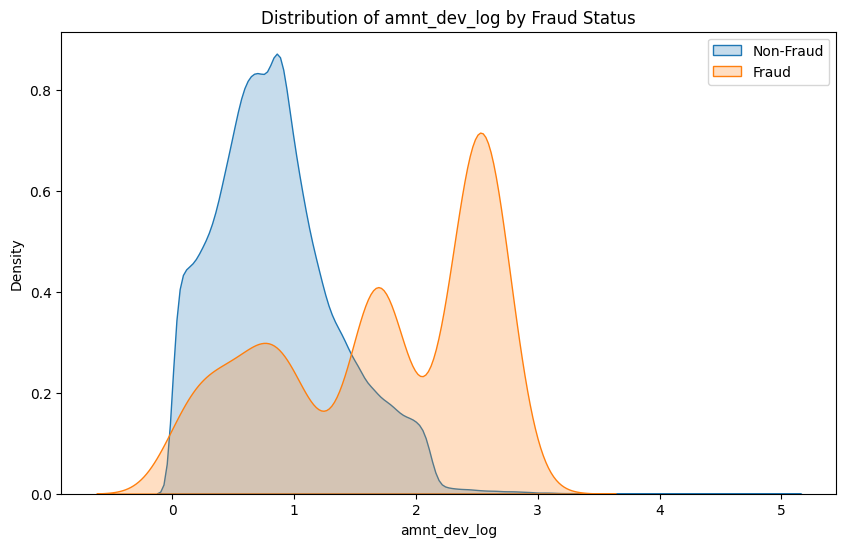

In [25]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['is_fraud'] == 0]['amnt_dev_log'], label='Non-Fraud', shade=True)
sns.kdeplot(df[df['is_fraud'] == 1]['amnt_dev_log'], label='Fraud', shade=True)
plt.xlabel('amnt_dev_log')
plt.ylabel('Density')
plt.title('Distribution of amnt_dev_log by Fraud Status')
plt.legend()
plt.show()

> Results:  There is a noticeable difference between the amnt_dev_log distribution of fraudulent and non-fraudulent transactions. The deviation is usually higher for fraudulent transactions.

### F3. New Feature "hr_dev"

> Rationale: This is to compute how much the transaction hour is deviating from the usual hour of transaction of a customer ( or cc_num)

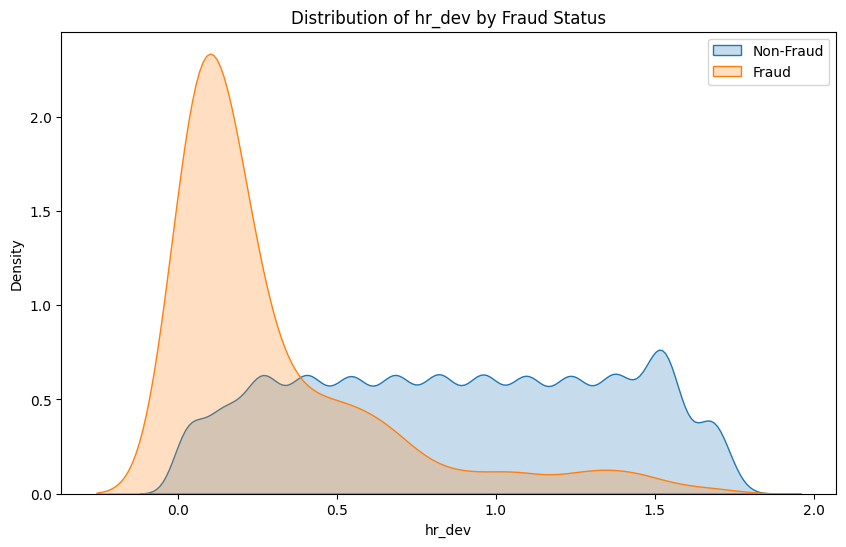

In [26]:
df['avg_hr'] = df.groupby('cc_num')['hour'].transform('mean')

df['hr_dev'] = np.abs(df['hour'] - df['avg_hr'])/np.std(df['hour'])

plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['is_fraud'] == 0]['hr_dev'], label='Non-Fraud', shade=True)
sns.kdeplot(df[df['is_fraud'] == 1]['hr_dev'], label='Fraud', shade=True)
plt.xlabel('hr_dev')
plt.ylabel('Density')
plt.title('Distribution of hr_dev by Fraud Status')
plt.legend()
plt.show()

> Results:  The non-fraud distribution has a long tail to the right, suggesting that non-fraudulent transactions occur at more varied hours i.e no specific time pattern, while fraudulent ones are more time-consistent

<hr>

## G. Data Preparation for Modeling

In [27]:
modeling_preparation_executive_summary = 'As we are doing an semi supervised learning, we will use normal transactions (non-fraud) in the training data and use that model to evaluate in validation and testing data which contains a mix of fraudulent and normal transactions.'

### G.1 Split Datasets

> Rationale: Use non fraud transactions in the training data for establishing pattern for normal transcations and a mix of fraud and non fraud transactions in the validation and test data for evaluating the performance of model - to see if can pick transactions that are different from legit transactions

In [28]:
from sklearn.model_selection import train_test_split
print("DataFrame shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFraud distribution:")
print(df['is_fraud'].value_counts(normalize=True) * 100)

X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

def prepare_fraud_detection_splits(X, y, val_size=0.2, test_size=0.2, random_state=42):

    normal_mask = y == 0
    fraud_mask = y == 1
    
    
    X_normal = X[normal_mask]
    y_normal = y[normal_mask]
    X_fraud = X[fraud_mask]
    y_fraud = y[fraud_mask]
    
    print(f"Normal transactions: {len(X_normal)}")
    print(f"Fraud transactions: {len(X_fraud)}")
    
    
    normal_remaining_size = val_size + test_size
    X_train, X_normal_remaining, y_train, y_normal_remaining = train_test_split(
        X_normal, 
        y_normal,
        test_size=normal_remaining_size,
        random_state=random_state
    )
    
    X_normal_val, X_normal_test, y_normal_val, y_normal_test = train_test_split(
        X_normal_remaining,
        y_normal_remaining,
        test_size=0.5,
        random_state=random_state
    )
    
    X_fraud_val, X_fraud_test, y_fraud_val, y_fraud_test = train_test_split(
        X_fraud,
        y_fraud,
        test_size=0.5,
        random_state=random_state
    )
    
    X_val = pd.concat([X_normal_val, X_fraud_val])
    y_val = pd.concat([y_normal_val, y_fraud_val])
    X_test = pd.concat([X_normal_test, X_fraud_test])
    y_test = pd.concat([y_normal_test, y_fraud_test])
    
    val_index = np.random.RandomState(random_state).permutation(len(X_val))
    test_index = np.random.RandomState(random_state).permutation(len(X_test))
    
    X_val = X_val.iloc[val_index]
    y_val = y_val.iloc[val_index]
    X_test = X_test.iloc[test_index]
    y_test = y_test.iloc[test_index]
    
    stats = {
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'train_fraud_ratio': y_train.mean(),
        'val_fraud_ratio': y_val.mean(),
        'test_fraud_ratio': y_test.mean()
    }
    
    return {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'stats': stats
    }

splits = prepare_fraud_detection_splits(X, y)


X_train = splits['X_train']
X_val = splits['X_val']
X_test = splits['X_test']
y_train = splits['y_train']
y_val = splits['y_val']
y_test = splits['y_test']

print("\nFinal Split Statistics:")
print(f"Training set shape: {splits['X_train'].shape}")
print(f"Validation set shape: {splits['X_val'].shape}")
print(f"Test set shape: {splits['X_test'].shape}")

print("\nFraud ratios:")
print(f"Training set: {splits['stats']['train_fraud_ratio']:.4f}")
print(f"Validation set: {splits['stats']['val_fraud_ratio']:.4f}")
print(f"Test set: {splits['stats']['test_fraud_ratio']:.4f}")

print("\nVerification:")
print("Training set only normal transactions:", (splits['y_train'] == 0).all())
print("Validation set has both classes:", len(splits['y_val'].unique()) == 2)
print("Test set has both classes:", len(splits['y_test'].unique()) == 2)

DataFrame shape: (260740, 19)

Columns: ['cc_num', 'acct_num', 'trans_num', 'unix_time', 'category', 'amt', 'is_fraud', 'merchant', 'merch_lat', 'merch_long', 'area', 'gender', 'hour', 'amnt_log', 'day_of_week', 'avg_log_amt', 'amnt_dev_log', 'avg_hr', 'hr_dev']

Fraud distribution:
is_fraud
0    99.548976
1     0.451024
Name: proportion, dtype: float64
Normal transactions: 259564
Fraud transactions: 1176

Final Split Statistics:
Training set shape: (155738, 18)
Validation set shape: (52501, 18)
Test set shape: (52501, 18)

Fraud ratios:
Training set: 0.0000
Validation set: 0.0112
Test set: 0.0112

Verification:
Training set only normal transactions: True
Validation set has both classes: True
Test set has both classes: True


> Results: Data Split has been executed.

<hr>

### G.2 Data Transformation Category

> Rationale: Category feature is a categorical feature which needs to be encoded befor modelling.

In [29]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore',drop='first').set_output(transform='pandas')
ohe.fit(X_train[['category']])

X_train_ohe = ohe.transform(X_train[['category']])
X_val_ohe = ohe.transform(X_val[['category']])
X_test_ohe = ohe.transform(X_test[['category']])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out(['category']))
X_val_ohe = pd.DataFrame(X_val_ohe, columns=ohe.get_feature_names_out(['category']))
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out(['category']))

X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_val = pd.concat([X_val, X_val_ohe], axis=1)
X_test = pd.concat([X_test, X_test_ohe], axis=1)

X_train.drop('category', axis=1, inplace=True)
X_val.drop('category', axis=1, inplace=True)
X_test.drop('category', axis=1, inplace=True)


> Results: Category has been one hot encoded.

### G.3 Data Transformation day_of_week

> Rationale: Category feature is a categorical feature which needs to be encoded befor modelling.

In [30]:
X_train_copy = X_train.copy()
X_val_copy = X_val.copy()
X_test_copy = X_test.copy()

In [31]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories=[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']])

# Fit on X_train and transform all datasets
X_train_copy['day_of_week'] = encoder.fit_transform(X_train[['day_of_week']])
X_val_copy['day_of_week'] = encoder.transform(X_val[['day_of_week']])
X_test_copy['day_of_week'] = encoder.transform(X_test[['day_of_week']])

In [32]:
X_train = X_train_copy
X_val = X_val_copy
X_test = X_test_copy

In [33]:
features_list = ['amt', 'hour', 'amnt_log','amnt_dev_log','hr_dev',
       'category_food_dining', 'day_of_week', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel']

> Results: Category has been one hot encoded and the final list of features have been updated.

### G.3 Data Transformation Numeric Features (amt, hour, amnt_log, amnt_dev_log, hr_dev) Scaling

> Rationale: Numeric features needs to be scaled 

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform='pandas')
num_features = ['amt', 'hour', 'amnt_log','amnt_dev_log','hr_dev']
scaler.fit(X_train[num_features])

X_train[num_features] = scaler.transform(X_train[num_features])
X_val[num_features] = scaler.transform(X_val[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

In [35]:
features_list = ['hour',
 'amnt_log',
 'amnt_dev_log',
 'hr_dev',
 'category_food_dining',
 'day_of_week',
 'category_gas_transport',
 'category_grocery_net',
 'category_grocery_pos',
 'category_health_fitness',
 'category_home',
 'category_kids_pets',
 'category_misc_net',
 'category_misc_pos',
 'category_personal_care',
 'category_shopping_net',
 'category_shopping_pos',
 'category_travel']

<hr>

## H. Assess Baseline Model

In [36]:
baseline_model_executive_summary = 'As the baseline model , we will use the One Class SVM  with default rbf kernel and train the model on training data and test it on both validation and testing data.'

### H.1  Predictions with Baseline Model

> Rationale: We will import the One Class SVM model  and train it on the training data with default rbf kernel and test it on both validation and testing dataset.

In [37]:
from sklearn.svm import OneClassSVM


svm = OneClassSVM()
svm.fit(X_train[features_list])

y_val_preds = svm.predict(X_val[features_list])
y_test_preds = svm.predict(X_test[features_list])




### H.2 Selection of Performance Metrics

> Rationale: The most important performance metric would be recall score i.e catching most genuinely suspicious behavior patterns and the roc-auc score is a valuable metric for understanding the model’s discriminatory power without committing to a specific threshold. We will also use precision and f1-score to see how balanced the model will be.

In [38]:


from sklearn.metrics import recall_score, roc_auc_score, precision_score,f1_score , roc_curve



In [39]:
features_list

['hour',
 'amnt_log',
 'amnt_dev_log',
 'hr_dev',
 'category_food_dining',
 'day_of_week',
 'category_gas_transport',
 'category_grocery_net',
 'category_grocery_pos',
 'category_health_fitness',
 'category_home',
 'category_kids_pets',
 'category_misc_net',
 'category_misc_pos',
 'category_personal_care',
 'category_shopping_net',
 'category_shopping_pos',
 'category_travel']

In [40]:
# Convert predictions for validation set
y_val_preds = np.where(y_val_preds == -1, 1, 0)

# Convert predictions for test set
y_test_preds = np.where(y_test_preds == -1, 1, 0)

### H.3 Baseline Model Performance

Recall on validation set: 0.9269
Recall on test set: 0.9218
Precision on validation set: 0.0205
Precision on test set: 0.0204
F1 on validation set: 0.0402
F1 on test set: 0.0400
ROC AUC on validation set: 0.7132
ROC AUC on test set: 0.7107


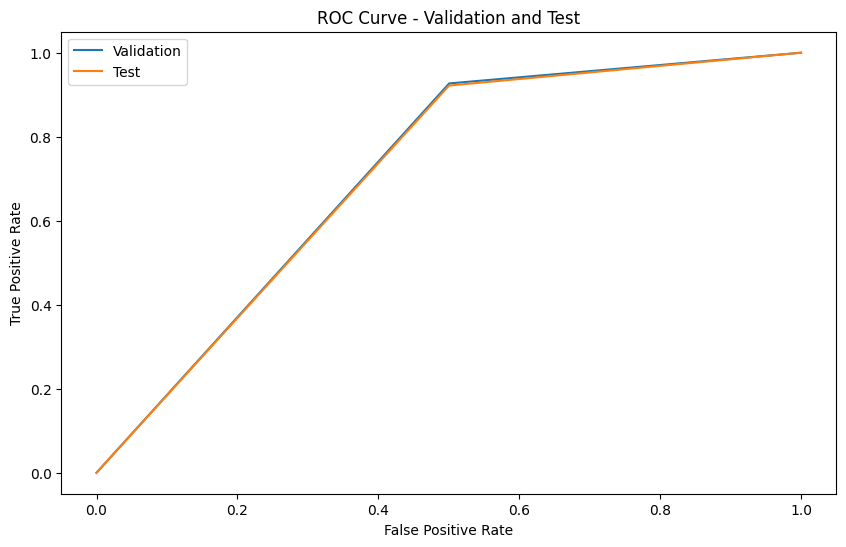

In [41]:
recall_val = recall_score(y_val, y_val_preds)
recall_test = recall_score(y_test, y_test_preds)
precision_val = precision_score(y_val, y_val_preds)
precision_test = precision_score(y_test, y_test_preds)
f1_val = f1_score(y_val, y_val_preds)

f1_test = f1_score(y_test, y_test_preds)
roc_auc_val = roc_auc_score(y_val, y_val_preds)
roc_auc_test = roc_auc_score(y_test, y_test_preds)

print(f"Recall on validation set: {recall_val:.4f}")
print(f"Recall on test set: {recall_test:.4f}")
print(f"Precision on validation set: {precision_val:.4f}")
print(f"Precision on test set: {precision_test:.4f}")
print(f"F1 on validation set: {f1_val:.4f}")
print(f"F1 on test set: {f1_test:.4f}")
print(f"ROC AUC on validation set: {roc_auc_val:.4f}")
print(f"ROC AUC on test set: {roc_auc_test:.4f}")

plt.figure(figsize=(10, 6))
fpr, tpr, thresholds = roc_curve(y_val, y_val_preds)
plt.plot(fpr, tpr, label='Validation')
fpr, tpr, thresholds = roc_curve(y_test, y_test_preds)
plt.plot(fpr, tpr, label='Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation and Test')
plt.legend()
plt.show()




ROC-AUC Validation: 0.8803
ROC-AUC Test: 0.8743


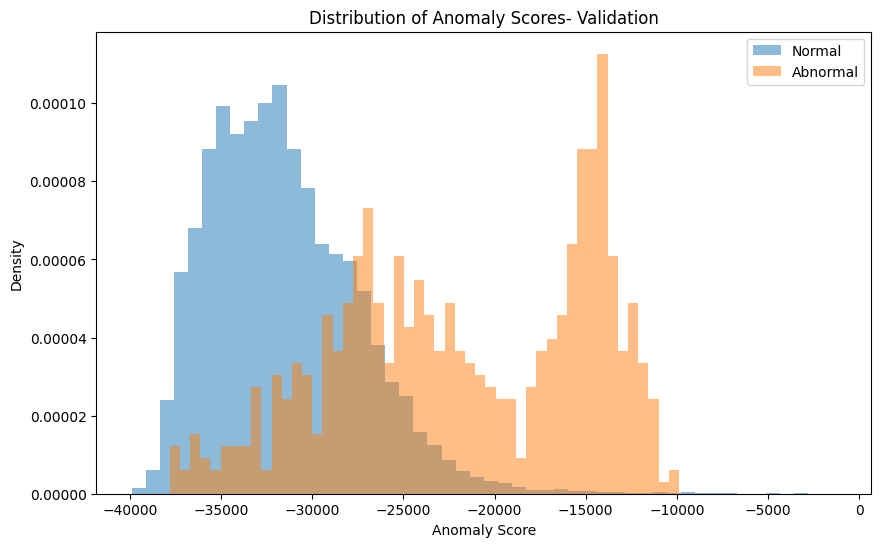

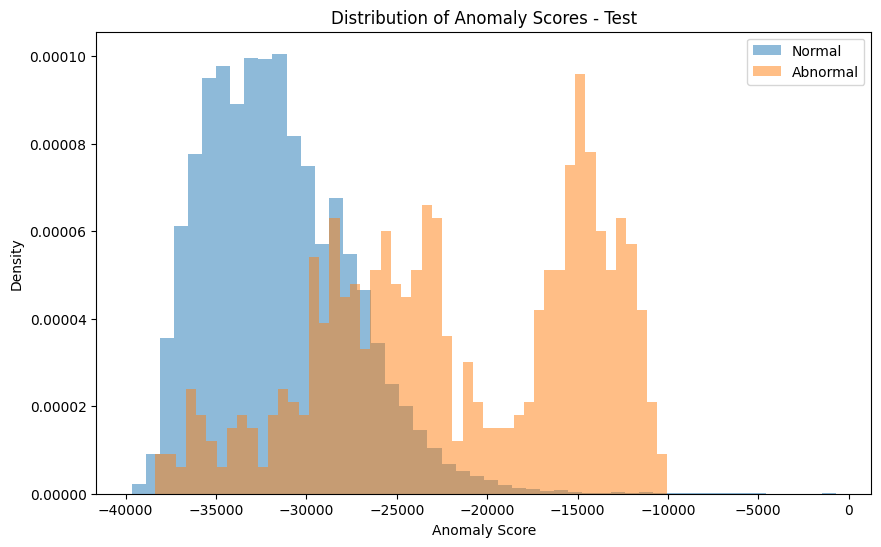

In [42]:

anomaly_scores_val = -svm.score_samples(X_val[features_list])
print(f"ROC-AUC Validation: {roc_auc_score(y_val, anomaly_scores_val):.4f}")
anomaly_scores_test = -svm.score_samples(X_test[features_list])
print(f"ROC-AUC Test: {roc_auc_score(y_test, anomaly_scores_test):.4f}")
# Visualize score distributions
plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores_val[y_val == 0], bins=50, alpha=0.5, label='Normal', density=True)
plt.hist(anomaly_scores_val[y_val == 1], bins=50, alpha=0.5, label='Abnormal', density=True)
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Distribution of Anomaly Scores- Validation')
plt.legend()
plt.show()



plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores_test[y_test == 0], bins=50, alpha=0.5, label='Normal', density=True)
plt.hist(anomaly_scores_test[y_test == 1], bins=50, alpha=0.5, label='Abnormal', density=True)
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Distribution of Anomaly Scores - Test')
plt.legend()
plt.show()

> Results: The bi-modal distribution in anomaly scores in both validation and testing data could be an indication that there could be two types of fraud patterns in the dataset. The roc-auc plot shows the baseline model in very stable in both validation and testing dataset. The similar roc curves for validation/test suggest stable, generalizable performance . The model trades off many false positives for catching most true frauds

## I. Train Machine Learning Model

In [43]:
train_model_executive_summary = 'We will use Local Outlier Factor model for novelty detection i.e to see abnormal spending patterns from the usual patterns from a customer.'

### I.1 Import Algorithm

> Rationale: The local outlier factor model is a standard approach used in novelty detection.

In [44]:
from sklearn.neighbors import LocalOutlierFactor

<hr>

### I.2 Set Hyperparameters

> Rationale: We will use the following parameter combination of LOF 

In [45]:
param_grid = {
    'n_neighbors': [50, 100, 200],
    'contamination': [0.01, 0.05, 0.1],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['auto']
}

<hr>

### I.3 Fit Model

In [46]:
def evaluate_lof(X_train, X_val, y_val, params):
    """
    Evaluate LOF model with given parameters
    Returns multiple metrics and anomaly scores
    """
    # Initialize and fit LOF
    lof = LocalOutlierFactor(novelty=True, **params)
    lof.fit(X_train[features_list])
    
    # Get anomaly scores
    anomaly_scores = -lof.score_samples(X_val[features_list])
    
    # Calculate metrics at different thresholds
    metrics = calculate_metrics_at_thresholds(anomaly_scores, y_val)
    
    return metrics, anomaly_scores, lof

def calculate_metrics_at_thresholds(scores, y_true, thresholds=None):
    """
    Calculate precision, recall, F1-score at different thresholds
    """
    if thresholds is None:
        # Use percentiles as thresholds
        thresholds = [
            np.percentile(scores, p) 
            for p in [30,50,60,90,95,99]
        ]
    
    results = []
    for threshold in thresholds:
        predictions = (scores > threshold).astype(int)
        
        result = {
            'threshold': threshold,
            'precision': precision_score(y_true, predictions),
            'recall': recall_score(y_true, predictions),
            'f1': f1_score(y_true, predictions),
            'auc': roc_auc_score(y_true, scores),
        }
        results.append(result)
    
    return pd.DataFrame(results)


results = []

# Grid search
for n_neighbors in param_grid['n_neighbors']:
    for contamination in param_grid['contamination']:
        for metric in param_grid['metric']:
            for algorithm in param_grid['algorithm']:
                params = {
                        'n_neighbors': n_neighbors,
                        'contamination': contamination,
                        'metric': metric,
                        'algorithm': algorithm,
                        
                }
                    
                try:
                    metrics_df, scores, _ = evaluate_lof(X_train[features_list], X_val[features_list], y_val, params
                 )
                        
                        # Get best recall score for this parameter combination
                    best_recall = metrics_df['recall'].max()
                    best_row = metrics_df.loc[metrics_df['recall'].idxmax()]
                        
                    results.append({
                            **params,
                            'best_f1': best_row['f1'],
                            'best_precision': best_row['precision'],
                            'best_recall': best_recall,
                            'best_threshold': best_row['threshold'],
                            'auc': best_row['auc']
                    })
                        
                    print(f"\nParameters: {params}")
                    print(f"Best recall-Score: {best_recall:.4f}")
                    print(f"Precision: {best_row['precision']:.4f}")
                    print(f"F1-score: {best_row['f1']:.4f}")
                    print(f"ROC-AUC: {best_row['auc']:.4f}")
                    print("-" * 50)
                        
                except Exception as e:
                    print(f"Error with parameters {params}: {str(e)}")
                    continue

# Convert results to DataFrame and sort by recall-score
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('best_recall', ascending=False)
 
print("\nTop 5 Parameter Combinations:")
print(results_df.head())

# Get best parameters
best_params = results_df.iloc[0].drop(['best_f1', 'best_precision', 'best_recall', 
                                     'best_threshold', 'auc']).to_dict()

print(f"\nBest Parameters: {best_params}")

/root/venv/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(

Parameters: {'n_neighbors': 50, 'contamination': 0.01, 'metric': 'euclidean', 'algorithm': 'auto'}
Best recall-Score: 0.9847
Precision: 0.0158
F1-score: 0.0310
ROC-AUC: 0.8972
--------------------------------------------------
/root/venv/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(

Parameters: {'n_neighbors': 50, 'contamination': 0.01, 'metric': 'manhattan', 'algorithm': 'auto'}
Best recall-Score: 0.9779
Precision: 0.0156
F1-score: 0.0308
ROC-AUC: 0.9245
--------------------------------------------------
/root/venv/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(

Par

In [47]:
lof = LocalOutlierFactor(novelty=True, **best_params)
lof.fit(X_train[features_list])

LocalOutlierFactor(contamination=0.1, metric='euclidean', n_neighbors=200,
                   novelty=True)

<hr>

### I.4 Model Technical Performance

/root/venv/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/root/venv/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


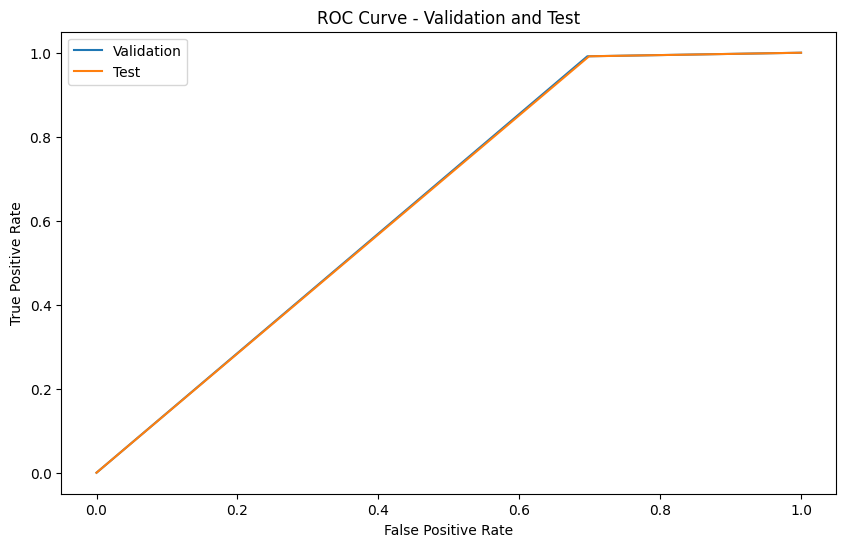

Recall-Validation: 0.9915
Precision-Validation: 0.0159
F1-Validation: 0.0312
ROC-AUC-Validation: 0.7132
Recall-Test: 0.9915
Precision-Test: 0.0158
F1-Test: 0.0311
ROC-AUC-Test: 0.7107


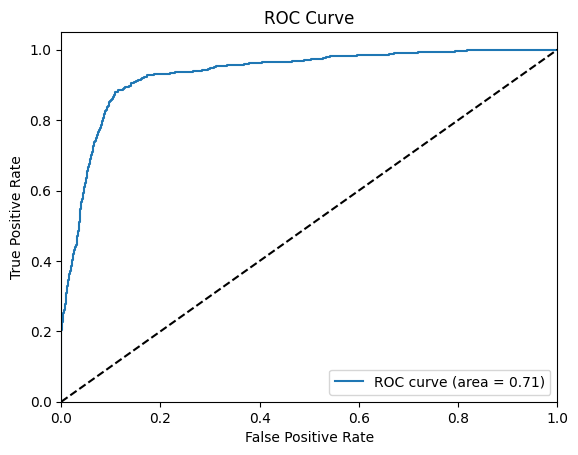

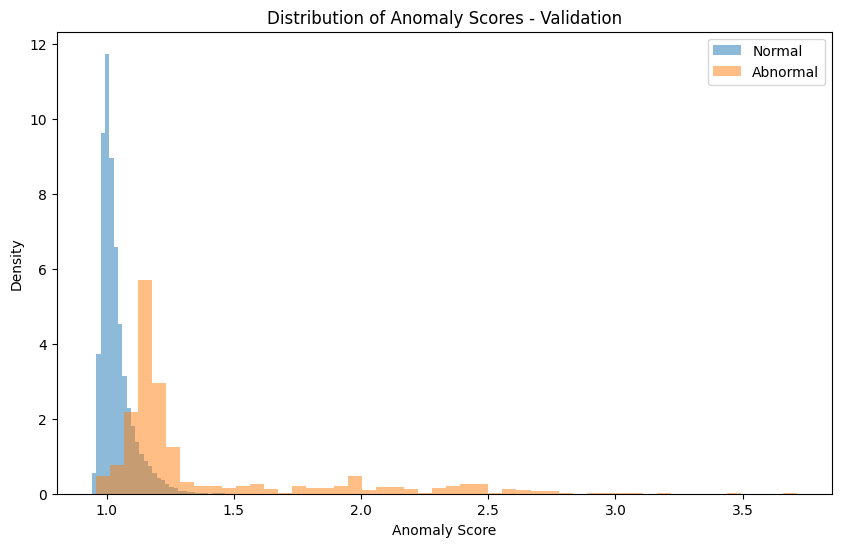

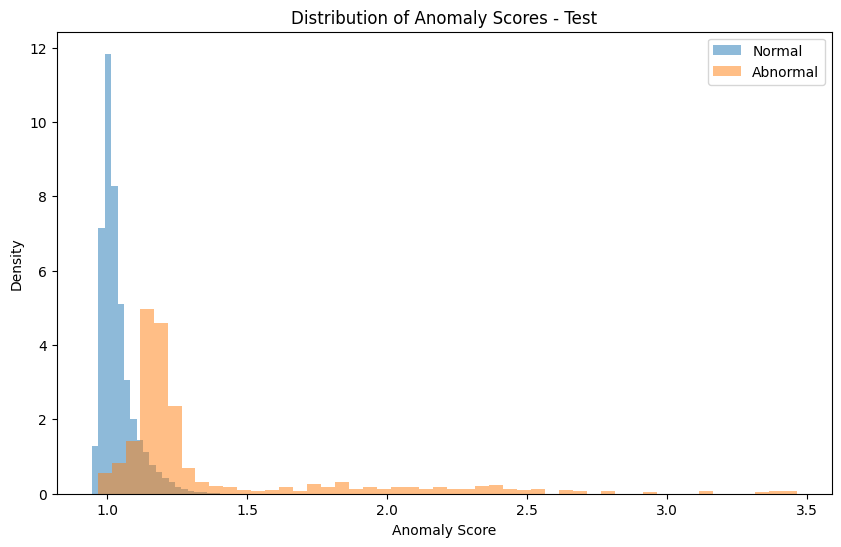

In [48]:
threshold = results_df.iloc[0]['best_threshold']
anomaly_scores_val = -lof.score_samples(X_val[features_list])


anomaly_scores_test = -lof.score_samples(X_test[features_list])

y_val_preds = (anomaly_scores_val > threshold).astype(int)
y_test_preds = (anomaly_scores_test > threshold).astype(int)


recall_val = recall_score(y_val, y_val_preds)
recall_test = recall_score(y_test, y_test_preds)

precision_val = precision_score(y_val, y_val_preds)
precision_test = precision_score(y_test, y_test_preds)

f1_val = f1_score(y_val, y_val_preds)
f1_test = f1_score(y_test, y_test_preds)

plt.figure(figsize=(10, 6))
fpr, tpr, thresholds = roc_curve(y_val, y_val_preds)
plt.plot(fpr, tpr, label='Validation')
fpr, tpr, thresholds = roc_curve(y_test, y_test_preds)
plt.plot(fpr, tpr, label='Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation and Test')
plt.legend()
plt.show()

print(f"Recall-Validation: {recall_val:.4f}")
print(f"Precision-Validation: {precision_val:.4f}")
print(f"F1-Validation: {f1_val:.4f}")
print(f"ROC-AUC-Validation: {roc_auc_val:.4f}")

print(f"Recall-Test: {recall_test:.4f}")
print(f"Precision-Test: {precision_test:.4f}")
print(f"F1-Test: {f1_test:.4f}")
print(f"ROC-AUC-Test: {roc_auc_test:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, anomaly_scores_test)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores_val[y_val == 0], bins=50, alpha=0.5, label='Normal', density=True)
plt.hist(anomaly_scores_val[y_val == 1], bins=50, alpha=0.5, label='Abnormal', density=True)
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Distribution of Anomaly Scores - Validation')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores_test[y_test == 0], bins=50, alpha=0.5, label='Normal', density=True)
plt.hist(anomaly_scores_test[y_test == 1], bins=50, alpha=0.5, label='Abnormal', density=True)
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Distribution of Anomaly Scores - Test')
plt.legend()
plt.show()

> Results: The model is effectively distinguishing between normal and abnormal transactions, with abnormal transactions typically receiving higher anomaly scores. The overlap in distribution could be an indication that model is failing to identify fraud transactions that seems "normal" i.e it doesn't have the nuance to flag these transactions as fraudulent.

<hr>

### I.5 Business Impact from Current Model Performance

In [49]:
results_df = pd.DataFrame({'recall': recall_test, 'precision': precision_test, 'f1': f1_test, 'auc': roc_auc_test}, index=[0])

print(results_df)


     recall  precision        f1       auc
0  0.991497   0.015809  0.031122  0.710725


> Results: Having  recall score of 90 %  means out of  all the transactions the model flags as anomalous or abnormal from the customer's usual spending pattern based on amount , time deviations , 90% of them are true fraudulent transactions. Only few suspicious activites are missed . This will help in minimizing financial loss of bank's customers. But this will come with a cost of low precision ( 10%) , which means out of 100 abnormal transactions only 10 are actually fraudulent transactions , which can increase the work load of fraud monitoring team of checking all these abnormal transactions and seeing if they are truly fraudulent or not.

<hr>

## L. Final Outcomes

> Key Learnings: An abnormal transaction is not necessarily a fraudulent transaction but still can help with monitoring suspicious activities if there is a significant deviation from the usual spending pattern of a customer.

> Recommendations: An Ensemble model can be tested with both LOF and OC-SVM model .

<hr>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=82d05eae-994c-4637-b420-581bad2cb92d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>